# Tooplox - Data Science Exercise 

In this notebook we would solve a Tooploox Data Science Exercise according to instructions in the *exercise_description.pdf* provided in the root folder of this notebook.

Let's start with loading data:

In [1]:
import pandas

main_dataset = pandas.read_csv("data.csv", header = None)

Let's have a glance at main statistics of main datasets columns:

In [2]:
print main_dataset.describe()

                 1              2             3             4             5    \
count     916.000000     916.000000  9.160000e+02  9.160000e+02  9.160000e+02   
mean    39889.541485   69421.946507  9.253133e+04  1.127782e+05  1.314772e+05   
std     24816.900947   58148.785461  9.892775e+04  1.442615e+05  1.924524e+05   
min         0.000000    3886.000000  8.608000e+03  9.396000e+03  9.989000e+03   
25%     23913.250000   38524.250000  4.782550e+04  5.549100e+04  6.192675e+04   
50%     34947.500000   56115.000000  7.026300e+04  8.120050e+04  9.110750e+04   
75%     50530.500000   84617.750000  1.088968e+05  1.300948e+05  1.475098e+05   
max    189528.000000  973903.000000  1.737730e+06  2.518686e+06  3.306221e+06   

                6             7             8             9             10   \
count  9.160000e+02  9.160000e+02  9.160000e+02  9.160000e+02  9.160000e+02   
mean   1.487397e+05  1.647916e+05  1.801862e+05  1.951114e+05  2.094496e+05   
std    2.390413e+05  2.832962e+05

## 1. Let's analyse $V(n)$ for $n = 24, 72, 168$.

Let's start with plotting main statistics for this columns:

In [3]:
print main_dataset[[24, 72, 168]].describe()

                24            72            168
count  9.160000e+02  9.160000e+02  9.160000e+02
mean   3.767655e+05  6.133033e+05  7.432098e+05
std    9.236467e+05  1.653969e+06  2.007964e+06
min    2.117300e+04  2.616200e+04  2.713900e+04
25%    1.248655e+05  1.483262e+05  1.533462e+05
50%    1.943575e+05  2.374175e+05  2.522870e+05
75%    3.266670e+05  4.336122e+05  5.222592e+05
max    1.528464e+07  2.291670e+07  2.789824e+07


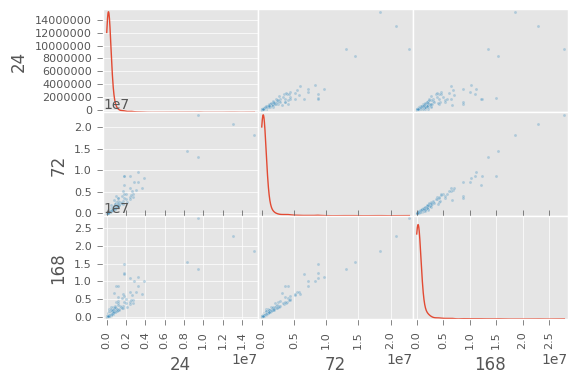

In [4]:
from matplotlib import pyplot as plt
from pandas.tools.plotting import scatter_matrix

plt.style.use('ggplot')

scatter_matrix(main_dataset[[24, 72, 168]], diagonal = 'kde', alpha = 0.3)
plt.show()

From the correlation matrix plotted above one can notice two things: enormous correlation of this columns and a $log-normal$ distribution density.

## 2 and 3 let's analyse $V(168)$ distribution.

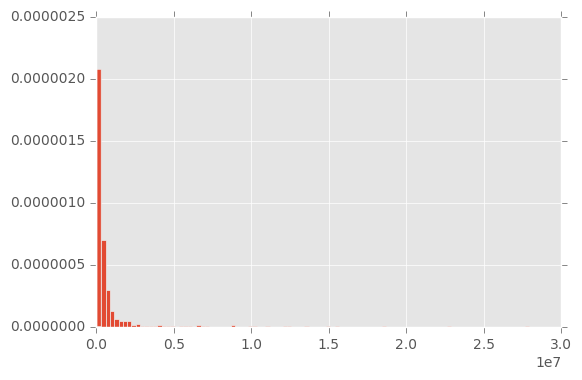

In [5]:
plt.hist(main_dataset[[168]], bins = 100, normed = True)
plt.show()

As I mentioned earlier - the shape of distribution is similiar to $f(x) = \frac{1}{x}$ function - this indicates that a $log$ transformation ($\ln'(x) = \frac{1}{x}$) sounds as reasonable option:

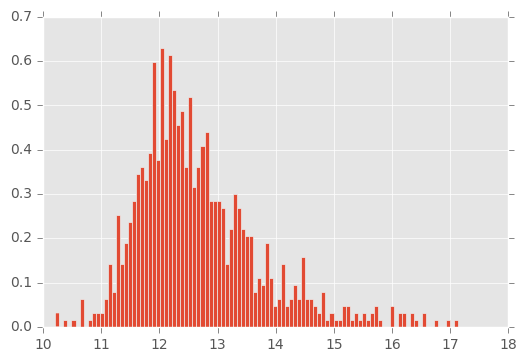

In [6]:
import numpy 

log_168 = main_dataset[[168]].apply(lambda x : numpy.log(1 + x))
plt.hist(log_168, bins = 100, normed = True)
plt.show()

One may notice on this distribution graph - a well known Gaussian bell.

## 4. Removing outliers.

Let's remove the outliers according to a $3\sigma$ rule:

In [7]:
mean_168 = main_dataset[168].mean()
sigma_168 = main_dataset[168].std()

not_outliers = abs(main_dataset[168] - mean_168) < 3 * sigma_168

print "Number of outliers: " + str((1 - not_outliers).sum())

main_dataset = main_dataset.loc[not_outliers].reset_index(drop = True)

Number of outliers: 17


## 5. Computting $corr\left(V(n), V(168)\right)$ for $n = 1, 2, 3, \dots, 24$:

In [8]:
main_log_dataset = main_dataset[range(1, (168 + 1))].apply(lambda x : numpy.log(1 + x))

main_log_dataset[range(1, 24 + 1) + [168]].corr()[168]

1      0.253588
2      0.784868
3      0.839550
4      0.854450
5      0.866215
6      0.877875
7      0.888547
8      0.898826
9      0.907889
10     0.914822
11     0.920128
12     0.924987
13     0.929117
14     0.932922
15     0.936677
16     0.940132
17     0.943484
18     0.946273
19     0.948695
20     0.950973
21     0.953135
22     0.955159
23     0.956987
24     0.958700
168    1.000000
Name: 168, dtype: float64

One may see that these correlations are pretty high and their values are increasing.

## 6. Splitting dataset into *train-test* parts.

In [9]:
shuffling_permutation = numpy.random.permutation(main_log_dataset.shape[0])
splitting_index = int(0.9 * main_log_dataset.shape[0])

train_log_dataset, test_log_dataset = main_log_dataset.loc[shuffling_permutation[:splitting_index]],\
                                      main_log_dataset.loc[shuffling_permutation[splitting_index:]]
    
print "Nb of train samples: " + str(train_log_dataset.shape[0])
print "Nb of test samples: " + str(test_log_dataset.shape[0])

Nb of train samples: 809
Nb of test samples: 90


## 7. Training linear models : $V(168) \sim V(n)$ for $n = 1, 2, \dots, 24$.

In [10]:
from sklearn.linear_model import LinearRegression


dict_of_single_models = dict()
numpy_y_data = train_log_dataset[168].as_matrix()

for n in xrange(1, 24 + 1):
    current_model = LinearRegression()
    current_data = train_log_dataset[n].as_matrix().reshape(-1, 1)
    current_model.fit(current_data, numpy_y_data)
    dict_of_single_models[n] = current_model

## 8. Training linear models : $V(168) \sim \left(V(1), V(2), \dots, V(n)\right)$ for $n = 1, 2, \dots, 24$.

In [11]:
from sklearn.linear_model import LinearRegression


dict_of_multiple_models = dict()
numpy_y_data = train_log_dataset[168].as_matrix()

for n in xrange(1, 24 + 1):
    current_model = LinearRegression()
    current_data = train_log_dataset[range(1, n + 1)].as_matrix().reshape(-1, n)
    current_model.fit(current_data, numpy_y_data)
    dict_of_multiple_models[n] = current_model

## 9. Computing *Relative Squared Error* for both kind of models:

*Relative Squared Error* is given by a equation $\frac{1}{|D|}\sum_{i = 1}^{|D|}\left(\frac{\hat{v}_i}{v_i} - 1\right)^2$

In [12]:
single_linear_model_error, multiple_linear_model_error = numpy.zeros((24)), numpy.zeros((24))
eps = 1e-6


def rse(y_true, y_pred):
    return (((y_true - y_pred) / numpy.maximum(eps, y_true)) ** 2).mean()

numpy_y_test_data = test_log_dataset[168].as_matrix()

for n in xrange(1, 24 + 1):
    current_single_data, current_multiple_data = test_log_dataset[n].as_matrix().reshape(-1, 1),\
                                                 test_log_dataset[range(1, n + 1)].as_matrix().reshape(-1, n)
    predicted_single_data, predicted_multiple_data = dict_of_single_models[n].predict(current_single_data),\
                                                     dict_of_multiple_models[n].predict(current_multiple_data)
    single_linear_model_error[n - 1], multiple_linear_model_error[n - 1] = rse(numpy_y_test_data, predicted_single_data),\
                                                                           rse(numpy_y_test_data, predicted_multiple_data) 

## 10. Plotting data:

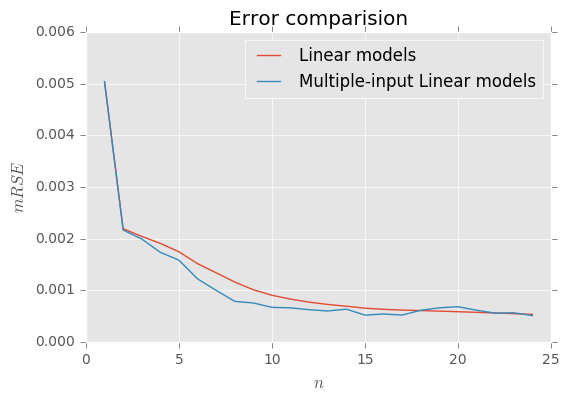

In [13]:
plt.plot(range(1, 24 + 1), single_linear_model_error, label = "Linear models")
plt.plot(range(1, 24 + 1), multiple_linear_model_error, label = "Multiple-input Linear models")
plt.legend(loc="best")
plt.title("Error comparision")
plt.xlabel("$n$")
plt.ylabel("$mRSE$")
plt.show()

## 11. Additional data analysis : PCA + t-SNE 

One can notice a huge correlation between different columns of a dataset. Let's try to catch this dependency by using a $PCA$ algorithm.

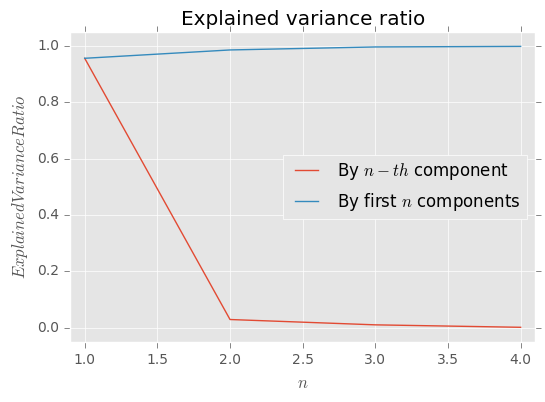

In [14]:
from sklearn.decomposition import PCA

train_log_numpy_data = train_log_dataset.as_matrix()

pca_decomposer = PCA()
pca_decomposer.fit(train_log_numpy_data)

plt.plot(range(1, 4 + 1),
         pca_decomposer.explained_variance_ratio_[:4], 
         label = "By $n-th$ component")
plt.plot(range(1, 4 + 1),
         pca_decomposer.explained_variance_ratio_.cumsum()[:4],
         label = "By first $n$ components")
plt.legend(loc="best")
plt.xlim([0.9, 4.1])
plt.ylim([-0.05, 1.05])
plt.title("Explained variance ratio")
plt.xlabel("$n$")
plt.ylabel("$Explained Variance Ratio$")
plt.show()

One can notice that first 3 components explain almost $100%$ of variance. Let's have a look at this components:

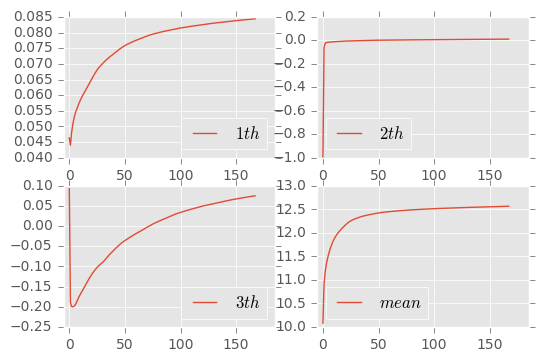

In [15]:
for i in range(0, 3):
    plt.subplot(2, 2, i + 1)
    plt.plot(pca_decomposer.components_[i], label = "$" + str(i + 1) + "th$")
    plt.legend(loc = "best")
    plt.xlim([-5, 185])
  
plt.subplot(2, 2, 4)
plt.plot(pca_decomposer.mean_, label = "$mean$")
plt.legend(loc = "best")
plt.xlim([-5, 185])

plt.show()

and on dependecies between coefficients of there components in $PCA$ decomposition:

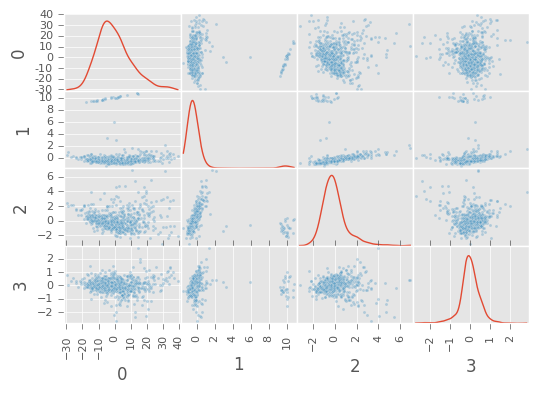

In [16]:
pca_transformed = pca_decomposer.transform(train_log_numpy_data)[:,:4]

scatter_matrix(pandas.DataFrame(pca_transformed), diagonal = 'kde', alpha = 0.3)
plt.show()

We can see an interesting behaviour of the coefficient of $2nd$ component which has two modes. One around $0$ and second around $10$. Knowing that the data is $log-$transformed this means that the high value of second coefficient indicates a really high increase in popularity. 

Let's compute a t-SNE transformation of this coefficients to get more insights into this phenomenon:

In [17]:
from sklearn.manifold import TSNE

tsne_decomposer = TSNE(2, method = 'exact')

tsne_decomposition = tsne_decomposer.fit_transform(pca_transformed)

Let's have a look at them:

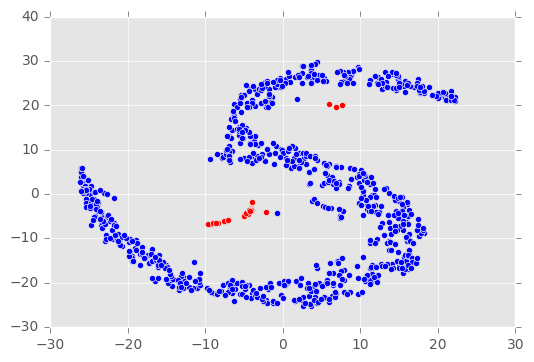

In [18]:
plt.scatter(tsne_decomposition[pca_transformed[:, 1] > 4, 0], 
            tsne_decomposition[pca_transformed[:, 1] > 4, 1],
            c = 'r')
plt.scatter(tsne_decomposition[pca_transformed[:, 1] <= 4, 0], 
            tsne_decomposition[pca_transformed[:, 1] <= 4, 1],
            c = 'b')

plt.show()

One can see that the second coefficient of the $PCA$ decomposition might be a good discriminator of a *sudden virality*. Those images which have this coefficient higher than other gained a lot of popularity during a first hour.